In [8]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, LSTM, Dropout
from keras.models import Model
from keras.optimizers import Adagrad, RMSprop

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import wallace
from AttentionLayer import *

importing Jupyter notebook from AttentionLayer.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/finalTests/'

In [4]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

In [5]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

In [4]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [7]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


# Data

In [5]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = wallace()

In [6]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [10]:
train_pos =get_pos('output_trainTestData/wallace_train_pos.csv')
test_pos = get_pos('output_trainTestData/wallace_test_pos.csv')

In [11]:
train_senti_blob =get_sentiment('output_trainTestData/wallace_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/wallace_test_data_sentiment_blob.csv')

# The model

In [12]:
#The model
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(comment_input)
x_first = Dense(600, activation='relu')(embedded_sequences)
x_first = Flatten()(x_first)

#Second part
senti_input_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second = Dense(600, activation='relu')(senti_input_blob)

#Thrid part
senti_input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third = Dense(600, activation='relu')(senti_input_pos)

#Concatination
concat = concatenate([x_first, x_second, x_third])

preds = Dense(2, activation='softmax')(concat)

model = Model(inputs=[comment_input, senti_input_blob, senti_input_pos], outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 891)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 891, 300)     3387600     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 891, 600)     180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 891)          0                                            
__________________________________________________________________________________________________
input_3 (I

# Test results

Instructions for updating:
Use tf.cast instead.


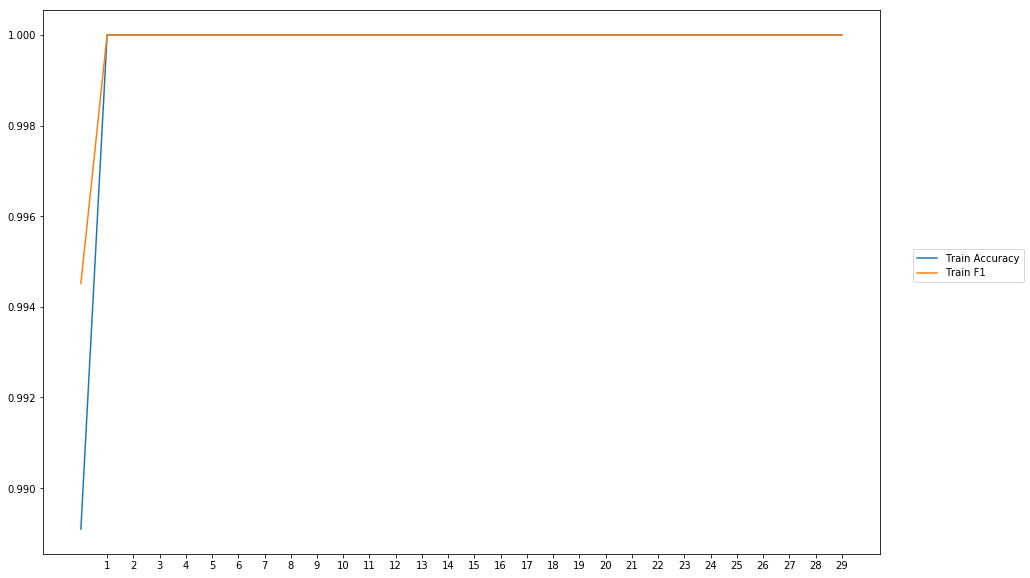


-----Test Scores----
Loss: 2.50102396884918e-07
Accuracy: 100.0
Precision: 99.99999997435897
Recall: 99.99999997435897
F1: 99.99999497435923


In [13]:
train_evaluate_three_inputs_with_terminate(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'Wallace')

# Basic Model

In [9]:
#Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 64
softmax = True
optimizer = RMSprop(lr=0.001, rho = 0.9, epsilon = 0.0000001)
lossfunction ='binary_crossentropy'

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
#Empedding: inputdim = length of vocabulary in input (text) data, outputdim = EMBEDDING_DIM
wv_layer = Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True)

#Input Layer
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Embedding Layer
embedded_sequences = wv_layer(comment_input)

#LSTM Layer
x = LSTM(400, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(embedded_sequences)

#Attention Layer
x = Attention()(x)

#Dropout Layer
x = Dropout(0.2)(x)

#Dense Layer
x = Dense(400, activation="relu")(x)

#Output (Dense) Layer
preds = Dense(2, activation='softmax')(x)

#Build the model
model = Model(inputs=[comment_input], outputs=preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 891)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 891, 300)          3387600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 891, 400)          1121600   
_________________________________________________________________
attention_2 (Attention)      (None, 400)               1291      
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 802       
Total para

Instructions for updating:
Use tf.cast instead.


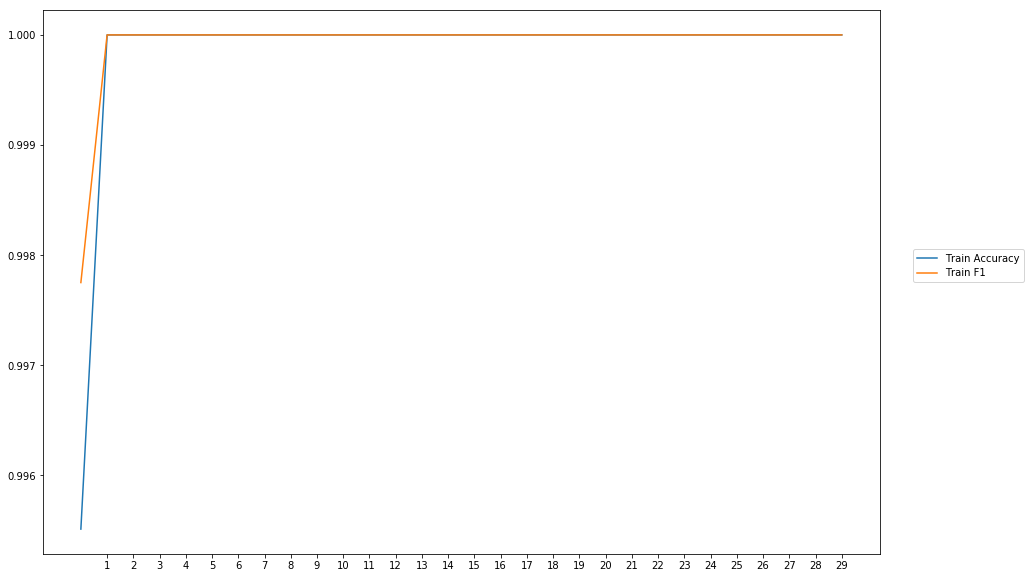


-----Test Scores----
Loss: 1.0960467033800551e-07
Accuracy: 100.0
Precision: 99.99999997435897
Recall: 99.99999997435897
F1: 99.99999497435923


In [12]:
train_evaluate_final_model(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_labels, test_data, test_labels, softmax, outputpath, 'BasicWallace')